<a href="https://colab.research.google.com/github/tsurikow/weather-ts-analysis-app/blob/main/benchmark/Data_analysis_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from multiprocessing import Process, Queue, Pool
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import time
pd.options.mode.chained_assignment = None

seasonal_temperatures = {
    "New York": {"winter": 0, "spring": 10, "summer": 25, "autumn": 15},
    "London": {"winter": 5, "spring": 11, "summer": 18, "autumn": 12},
    "Paris": {"winter": 4, "spring": 12, "summer": 20, "autumn": 13},
    "Tokyo": {"winter": 6, "spring": 15, "summer": 27, "autumn": 18},
    "Moscow": {"winter": -10, "spring": 5, "summer": 18, "autumn": 8},
    "Sydney": {"winter": 12, "spring": 18, "summer": 25, "autumn": 20},
    "Berlin": {"winter": 0, "spring": 10, "summer": 20, "autumn": 11},
    "Beijing": {"winter": -2, "spring": 13, "summer": 27, "autumn": 16},
    "Rio de Janeiro": {"winter": 20, "spring": 25, "summer": 30, "autumn": 25},
    "Dubai": {"winter": 20, "spring": 30, "summer": 40, "autumn": 30},
    "Los Angeles": {"winter": 15, "spring": 18, "summer": 25, "autumn": 20},
    "Singapore": {"winter": 27, "spring": 28, "summer": 28, "autumn": 27},
    "Mumbai": {"winter": 25, "spring": 30, "summer": 35, "autumn": 30},
    "Cairo": {"winter": 15, "spring": 25, "summer": 35, "autumn": 25},
    "Mexico City": {"winter": 12, "spring": 18, "summer": 20, "autumn": 15},
}

# Сопоставление месяцев с сезонами
month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

# Генерация данных о температуре
def generate_realistic_temperature_data(cities, num_years=10):
    dates = pd.date_range(start="2010-01-01", periods=365 * num_years, freq="D")
    data = []

    for city in cities:
        for date in dates:
            season = month_to_season[date.month]
            mean_temp = seasonal_temperatures[city][season]
            # Добавляем случайное отклонение
            temperature = np.random.normal(loc=mean_temp, scale=5)
            data.append({"city": city, "timestamp": date, "temperature": temperature})

    df = pd.DataFrame(data)
    df['season'] = df['timestamp'].dt.month.map(lambda x: month_to_season[x])
    return df

# Генерация данных
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()))
data.to_csv('temperature_data.csv', index=False)

In [ ]:
DATE_COLUMN = 'timestamp'
DATA_PATH = 'temperature_data.csv'

def load_data(data_path):
    data = pd.read_csv(data_path)
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis='columns', inplace=True)
    data[DATE_COLUMN] = pd.to_datetime(data[DATE_COLUMN])
    data = data.set_index(DATE_COLUMN)
    return data

data = load_data(DATA_PATH)

In [ ]:
data.head(5)

,city,temperature,season
timestamp,,,
2010-01-01,New York,3.443041,winter
2010-01-02,New York,1.222145,winter
2010-01-03,New York,-9.480158,winter
2010-01-04,New York,1.799251,winter
2010-01-05,New York,2.119879,winter


In [ ]:
city_list = data['city'].value_counts().index.tolist()

In [ ]:
df = data.groupby(['season'])['temperature'].transform('mean')

In [ ]:
df

,temperature
timestamp,
2010-01-01,9.871947
2010-01-02,9.871947
2010-01-03,9.871947
2010-01-04,9.871947
2010-01-05,9.871947
...,...
2019-12-25,9.871947
2019-12-26,9.871947
2019-12-27,9.871947


In [ ]:
# Augmented Dickey-Fuller test
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

# KPSS test
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    if (kpsstest[1] > 0.05) & (kpsstest[3]['5%'] > kpsstest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
def plot_acf_pacf(model, lags=365):
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid.values.squeeze(), lags=lags, ax=ax2)
    fig.show()

Results of Dickey-Fuller Test:
Test Statistic                   -4.885139
p-value                           0.000037
Lags Used                         9.000000
Number of Observations Used    3640.000000
Critical Value (1%)              -3.432148
Critical Value (5%)              -2.862334
Critical Value (10%)             -2.567193
dtype: float64
Stationary

Results of KPSS Test:
Test Statistic            0.037701
p-value                   0.100000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Stationary


<ipython-input-114-af031ebafd53>:25: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




<Axes: xlabel='timestamp'>

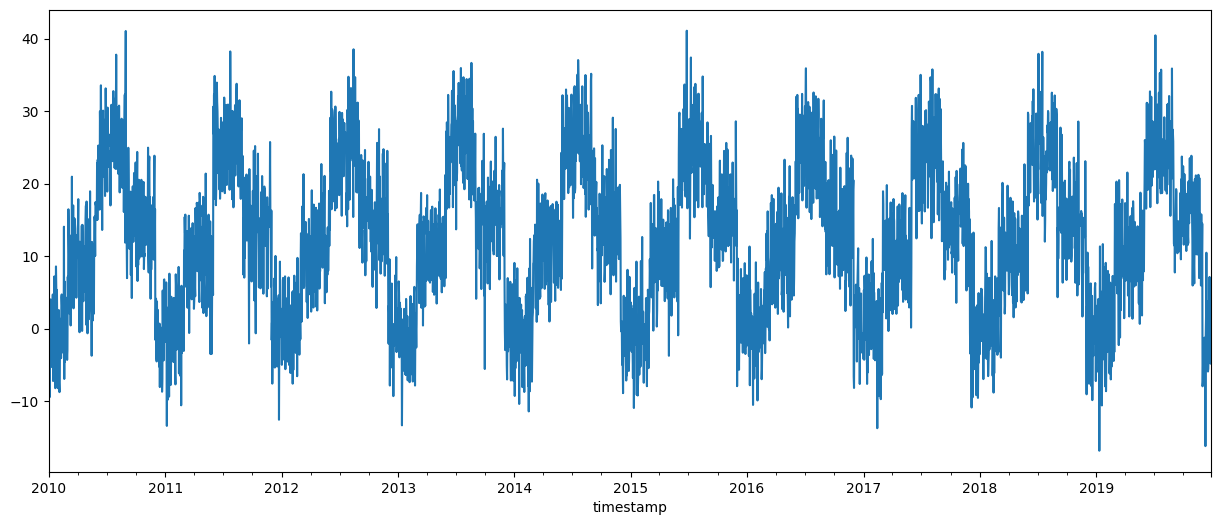

In [ ]:
city_sample = city_data = data[data['city'] == 'New York']['temperature']
split = int(len(city_sample) * 0.80)
ts1 = city_sample.iloc[:split]
ts2 = city_sample.iloc[split:]
city_sample_train = city_sample[:-len(ts2)]
endog = city_sample_train
adf_test(city_sample)
print('')
kpss_test(city_sample)
city_sample.plot(figsize=(15,6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2920
Model:                        SARIMAX   Log Likelihood              -12283.353
Date:                Fri, 20 Dec 2024   AIC                          24568.706
Time:                        17:25:18   BIC                          24574.685
Sample:                    01-01-2010   HQIC                         24570.860
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       263.8494      8.974     29.402      0.000     246.261     281.438
Ljung-Box (L1) (Q):                1635.64   Jarque-Bera (JB):                57.36
Prob(Q):                              0.00   Pr

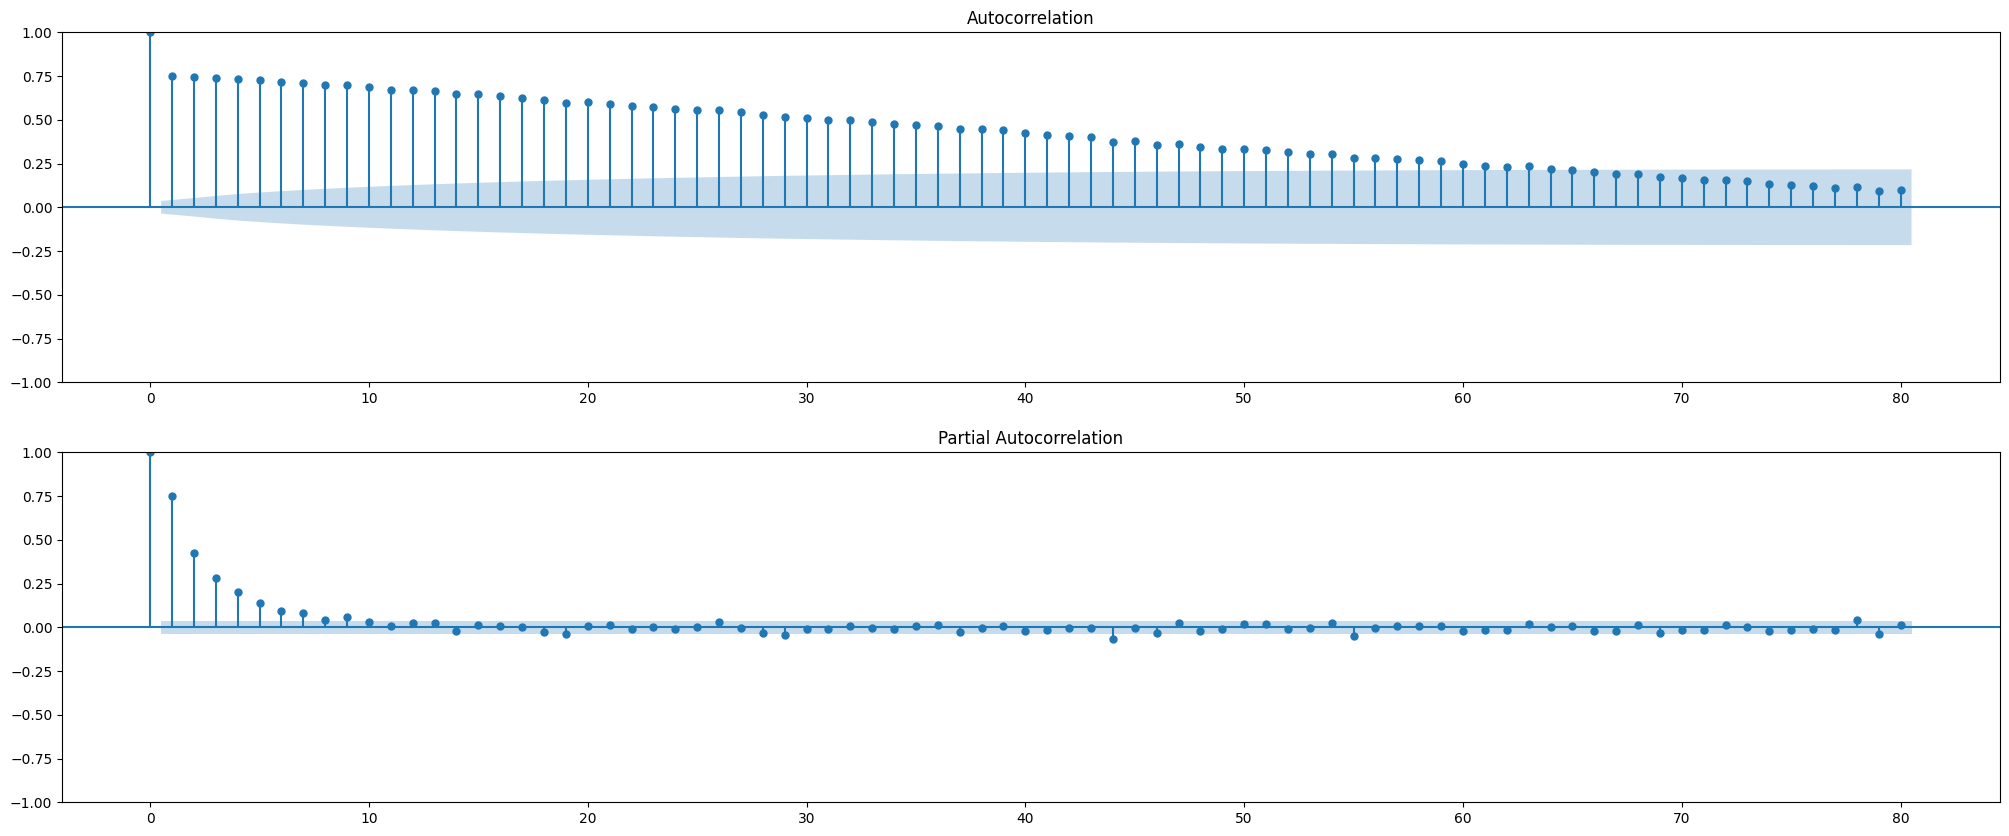

In [ ]:
city_sarimax = sm.tsa.SARIMAX(endog=city_sample_train, order=[0,0,0], seasonal_order=[0,0,0,0]).fit()
print(city_sarimax.summary())
plot_acf_pacf(city_sarimax, lags=80)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 2920
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -9211.739
Date:                            Fri, 20 Dec 2024   AIC                          18433.479
Time:                                    17:31:10   BIC                          18463.375
Sample:                                01-01-2010   HQIC                         18444.247
                                     - 12-29-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9963      0.002    590.786      0.000       0.993       1.000
ma.L1         -0.7795      0.011   

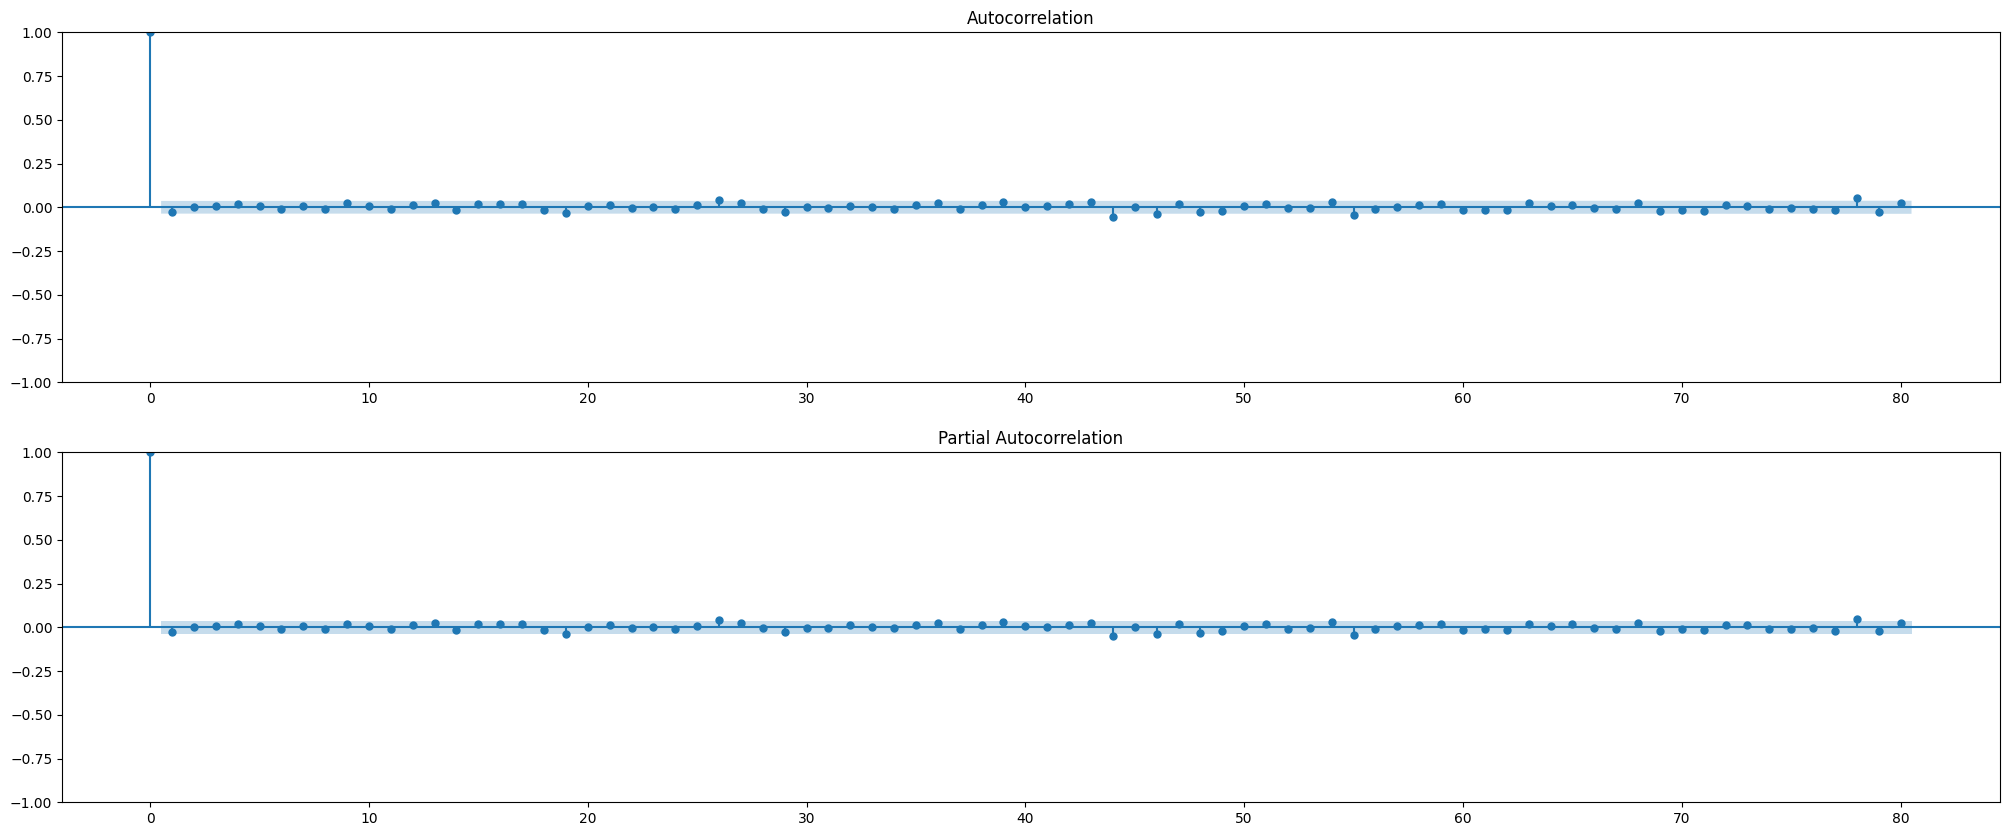

In [ ]:
city_sarimax = sm.tsa.SARIMAX(endog=city_sample_train, order=[1,0,1], seasonal_order=[1,0,1,12]).fit()
print(city_sarimax.summary())
plot_acf_pacf(city_sarimax, lags=80)

In [ ]:
def qualityMAPE(x,y):
    qlt = ((x-y).abs()/x.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

In [ ]:
predict = city_sarimax.get_prediction()
result = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'train_prediction'})
ts_frc = city_sample[-len(ts2):]
forecast = city_sarimax.forecast(steps=len(ts_frc))
fig = px.line(pd.DataFrame(city_sample).merge(
    result,
    how = 'left', left_index = True, right_index = True
    ).merge(
        pd.DataFrame(forecast).rename(columns = {'predicted_mean':'forecast'}),
        how = 'left', left_index = True, right_index = True
    ), title='New York weather forecast', render_mode="SVG")
fig.show()
city_sample_mape = qualityMAPE(ts2, forecast)[0]
print("MAPE: ", city_sample_mape)

MAPE:  1.0659278651561765


<ipython-input-121-43146da35306>:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



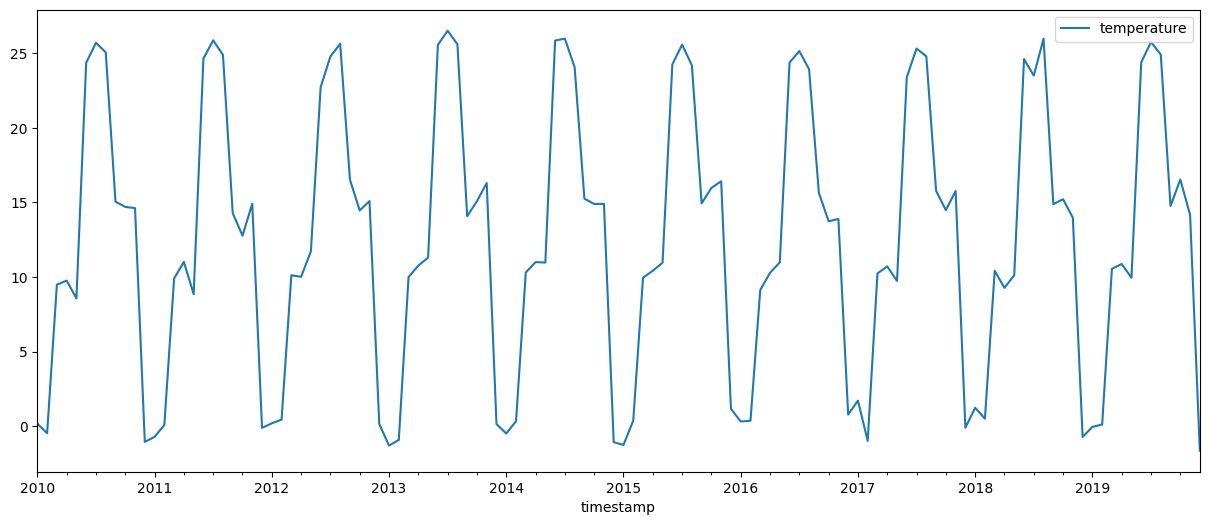

In [ ]:
city_sample_M = pd.DataFrame(city_sample.resample('M').mean())
city_sample_M.plot(figsize=(15,6));

In [ ]:
adf_test(city_sample_M)
print('')
kpss_test(city_sample_M)

Results of Dickey-Fuller Test:
Test Statistic                  -2.962151
p-value                          0.038583
Lags Used                       11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
Stationary

Results of KPSS Test:
Test Statistic           0.02002
p-value                  0.10000
Lags Used                5.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64
Stationary


<ipython-input-114-af031ebafd53>:25: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -132.285
Date:                            Fri, 20 Dec 2024   AIC                            274.569
Time:                                    17:25:31   BIC                            287.339
Sample:                                01-31-2010   HQIC                           279.729
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1167      0.099      1.179      0.238      -0.077       0.311
ma.L1         -0.9592      0.073   

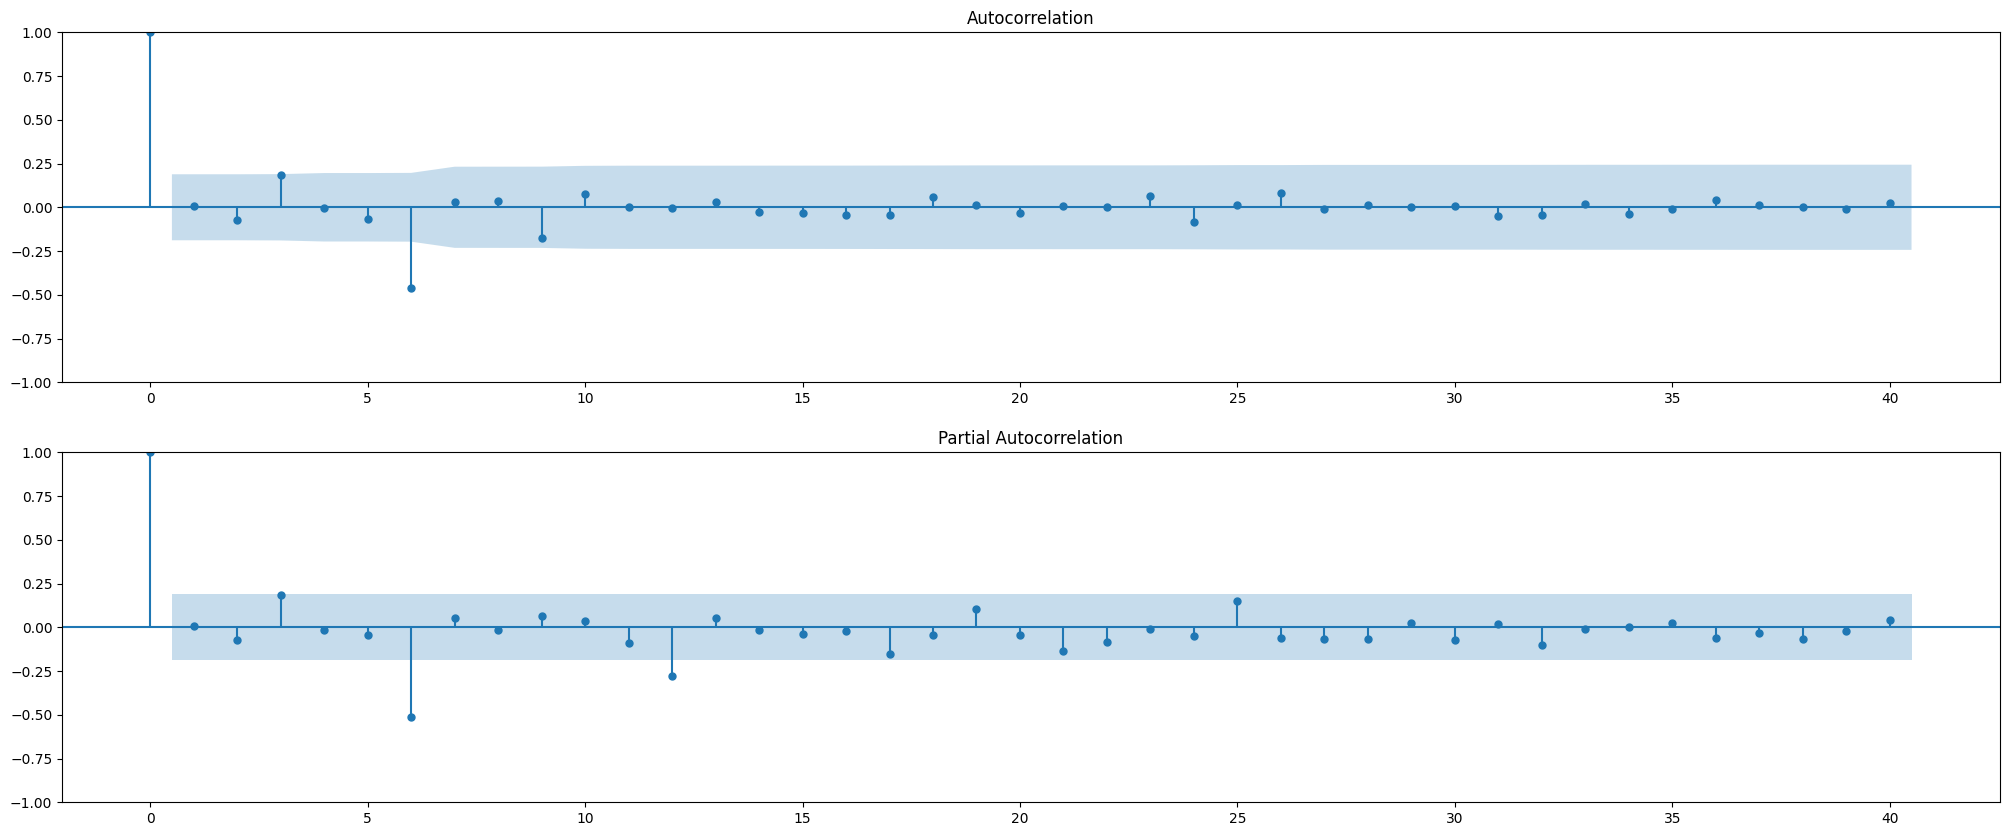

In [ ]:
split = 12
ts1 = city_sample_M.iloc[:-split]
ts2 = city_sample_M.iloc[-split:]
city_sample_M_train = city_sample_M[:-len(ts2)]
city_M_sarimax = sm.tsa.SARIMAX(endog=city_sample_M_train, order=[1,1,1], seasonal_order=[1,1,1,12]).fit()
print(city_M_sarimax.summary())
plot_acf_pacf(city_M_sarimax, lags=40)

In [ ]:
predict = city_M_sarimax.get_prediction()
result = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'train_prediction'})
ts_frc = city_sample_M[-len(ts2):]
forecast = city_M_sarimax.forecast(steps=len(ts_frc))
fig = px.line(pd.DataFrame(city_sample_M).merge(
    result,
    how = 'left', left_index = True, right_index = True
    ).merge(
        pd.DataFrame(forecast).rename(columns = {'predicted_mean':'forecast'}),
        how = 'left', left_index = True, right_index = True
    ), title='New York monthly weather forecast', render_mode="SVG")
fig.show()
city_sample_M_mape = qualityMAPE(ts2, forecast)[0]
print("MAPE: ", city_sample_M_mape)

MAPE:  2019-01-31 00:00:00   NaN
2019-02-28 00:00:00   NaN
2019-03-31 00:00:00   NaN
2019-04-30 00:00:00   NaN
2019-05-31 00:00:00   NaN
2019-06-30 00:00:00   NaN
2019-07-31 00:00:00   NaN
2019-08-31 00:00:00   NaN
2019-09-30 00:00:00   NaN
2019-10-31 00:00:00   NaN
2019-11-30 00:00:00   NaN
2019-12-31 00:00:00   NaN
temperature           NaN
dtype: float64


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -166.665
Date:                              Fri, 20 Dec 2024   AIC                            339.331
Time:                                      17:25:33   BIC                            347.349
Sample:                                  01-31-2010   HQIC                           342.582
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3847      0.077     -4.989      0.000      -0.536      -0.234
ma.S.L12      -0.99

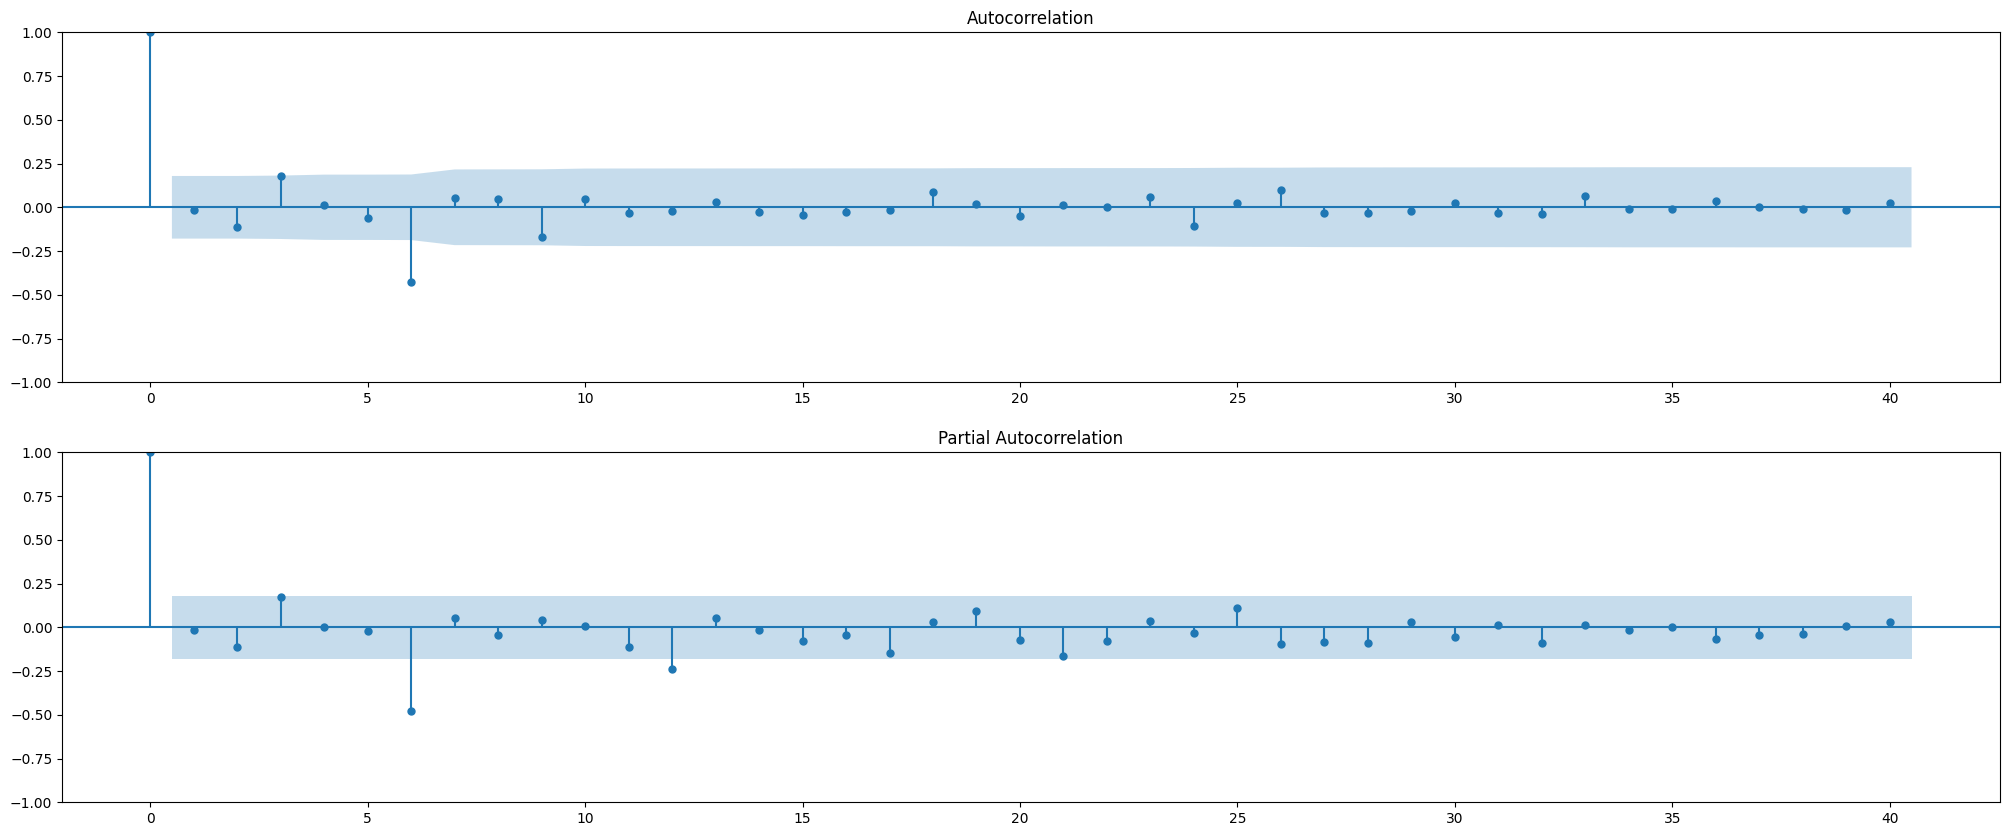

In [ ]:
city_M_sarimax = sm.tsa.SARIMAX(endog=city_sample_M, order=[1,1,0], seasonal_order=[0,1,1,12]).fit(maxiter=200, method='bfgs', disp=False)
print(city_M_sarimax.summary())
plot_acf_pacf(city_M_sarimax, lags=40)

In [ ]:
predict = city_M_sarimax.get_prediction()
result = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'train_prediction'})
forecast = city_M_sarimax.forecast(steps=36)
city_sample_final = pd.DataFrame(city_sample_M).merge(
    result,
    how = 'left', left_index = True, right_index = True
    ).merge(
        pd.DataFrame(forecast).rename(columns = {'predicted_mean':'forecast'}),
        how = 'outer', left_index = True, right_index = True)
fig = px.line(city_sample_final, title='New York monthly weather forecast', render_mode="SVG")
fig.show()

In [ ]:
future_mean = city_sample_final['forecast'].iloc[-36:].mean()
future_mean

10.991853527658469

In [ ]:
past_mean = city_sample_final['temperature'].iloc[-72:-36].mean()
past_mean

12.498961225352259

In [ ]:
future_last_mean = city_sample_final['forecast'].iloc[-12:].mean()
future_last_mean

10.85285508426231

In [ ]:
def trend_sarimax(data, city, steps=36):
    # SARIMAX для прогноза долгосрочного тренда
    city_ts = data[data['city'] == city]['temperature']
    city_ts_M = pd.DataFrame(city_ts.resample('ME').mean())
    city_M_sarimax = sm.tsa.SARIMAX(endog=city_ts_M, order=[1,1,1], seasonal_order=[1,1,1,12]).fit(maxiter=200, method='bfgs', disp=False)
    predict = city_M_sarimax.get_prediction()
    result = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'train_prediction'})
    forecast = city_M_sarimax.forecast(steps=steps)
    city_ts_final = pd.DataFrame(city_ts_M).merge(
    result,
    how = 'left', left_index = True, right_index = True
    ).merge(
        pd.DataFrame(forecast).rename(columns = {'predicted_mean':'forecast'}),
        how = 'outer', left_index = True, right_index = True)
    future_mean = city_ts_final['forecast'].iloc[-steps:].mean()
    past_mean = city_ts_final['temperature'].iloc[-steps*2:-steps].mean()
    future_last_mean = city_ts_final['forecast'].iloc[-12:].mean()
    trend = 'Unknown'
    if past_mean > future_mean > future_last_mean:
        trend = 'Decreasing mean temp'
    elif past_mean < future_mean < future_last_mean:
        trend = 'Increasing mean temp'
    elif future_mean < future_last_mean:
        trend = 'Probably increasing mean temp'
    elif future_mean > future_last_mean:
        trend = 'Probably decreasing mean temp'
    return trend



In [ ]:
def city_data_processing(data, city, window=30, steps=36):
    city_data = data[data['city'] == city]
    city_ts = city_data['temperature']
    city_data['smoothed'] = np.convolve(city_data['temperature'], np.ones(window)/window, 'same')
    city_data['season_mean'] = city_data.groupby(['season'])['temperature'].transform('mean')
    city_data['std'] = city_data.groupby(['season'])['temperature'].transform('std')
    city_data['mean+2std'] = city_data['season_mean'] + 2*city_data['std']
    city_data['mean-2std'] = city_data['season_mean'] - 2*city_data['std']
    city_data['anomaly'] = np.where((city_data['temperature'] < city_data['mean+2std']), 0, 1)
    city_data['anomaly'] = np.where((city_data['temperature'] > city_data['mean-2std']), 0, 1)
    trend = trend_sarimax(data, city, steps)

    return city_data, trend, city

In [ ]:
data_list = []
start = time.time()
for city in city_list:
    results = city_data_processing(data, city, window=30)
    data_list.append(results[0])
    print(f'{results[2]} longterm trend: ', results[1])
processed_data = pd.concat(data_list)
end = time.time()
single_proc = end - start
print('single proc: ', single_proc)

New York longterm trend:  Increasing mean temp
London longterm trend:  Decreasing mean temp
Paris longterm trend:  Decreasing mean temp
Tokyo longterm trend:  Decreasing mean temp
Moscow longterm trend:  Decreasing mean temp
Sydney longterm trend:  Decreasing mean temp
Berlin longterm trend:  Decreasing mean temp
Beijing longterm trend:  Increasing mean temp
Rio de Janeiro longterm trend:  Increasing mean temp
Dubai longterm trend:  Decreasing mean temp
Los Angeles longterm trend:  Decreasing mean temp
Singapore longterm trend:  Decreasing mean temp
Mumbai longterm trend:  Increasing mean temp
Cairo longterm trend:  Probably increasing mean temp
Mexico City longterm trend:  Increasing mean temp
single proc:  34.88457989692688


In [ ]:
processed_data

,city,temperature,season,smoothed,season_mean,std,mean+2std,mean-2std,anomaly
timestamp,,,,,,,,,
2010-01-01,New York,3.443041,winter,-0.381933,-0.098515,4.784816,9.471116,-9.668146,0
2010-01-02,New York,1.222145,winter,-0.462033,-0.098515,4.784816,9.471116,-9.668146,0
2010-01-03,New York,-9.480158,winter,-0.397784,-0.098515,4.784816,9.471116,-9.668146,0
2010-01-04,New York,1.799251,winter,-0.157981,-0.098515,4.784816,9.471116,-9.668146,0
2010-01-05,New York,2.119879,winter,0.043939,-0.098515,4.784816,9.471116,-9.668146,0
...,...,...,...,...,...,...,...,...,...
2019-12-25,Mexico City,11.932090,winter,7.611660,11.836612,4.895831,21.628275,2.044950,0
2019-12-26,Mexico City,5.952198,winter,7.122786,11.836612,4.895831,21.628275,2.044950,0
2019-12-27,Mexico City,11.831444,winter,6.954795,11.836612,4.895831,21.628275,2.044950,0


In [ ]:
def worker(city):
    return city_data_processing(data, city, 30)

def main():
    #n_worker = 4
    data_list = []

    with Pool() as pool:
        for result in pool.imap(worker, city_list):
            data_list.append(result[0])
            print(f'{result[2]} longterm trend: ', result[1])

        processed_data = pd.concat(data_list)



if __name__ == '__main__':
    start = time.time()
    main()
    end = time.time()
    multi_pool = end - start
    print('multi Pool: ', multi_pool)

New York longterm trend:  Increasing mean temp
London longterm trend:  Decreasing mean temp
Paris longterm trend:  Decreasing mean temp
Tokyo longterm trend:  Decreasing mean temp
Moscow longterm trend:  Decreasing mean temp
Sydney longterm trend:  Decreasing mean temp
Berlin longterm trend:  Decreasing mean temp
Beijing longterm trend:  Increasing mean temp
Rio de Janeiro longterm trend:  Increasing mean temp
Dubai longterm trend:  Decreasing mean temp
Los Angeles longterm trend:  Decreasing mean temp
Singapore longterm trend:  Decreasing mean temp
Mumbai longterm trend:  Increasing mean temp
Cairo longterm trend:  Probably increasing mean temp
Mexico City longterm trend:  Increasing mean temp
multi Pool:  61.96232056617737


In [ ]:
print("_"*20)
print(f'multiprocessing: {"%.2f" %multi_pool}s')
print(f'single: {"%.2f" %single_proc}s')
if single_proc > multi_pool:
    print(f'Multi {"%.1f" % (single_proc/multi_pool)}x times faster')
else:
    print(f'Single {"%.1f" %(multi_pool/single_proc)}x times faster')

____________________
multiprocessing: 61.96s
single: 34.88s
Single 1.8x times faster
